In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import TruncatedSVD
from sinkhorn import sinkhorn
from builders import image2array, array2cost, image2array, transfer_color, array2image

### Understanding how the truncated svd in scikitlearn works

In [2]:
X=np.random.rand(5,6)*100
X=np.round(X,0)

In [3]:
X

array([[41., 59., 48., 67., 31., 78.],
       [22., 46., 25., 46., 68., 78.],
       [72.,  0., 54., 68., 83., 11.],
       [27., 60., 54., 99., 72., 39.],
       [70., 41., 66., 97., 37., 84.]])

In [8]:
svd=TruncatedSVD(2) #choosing the rank r of the approximation, here a rank 3 approximation
US=svd.fit_transform(X)
V=svd.components_

In [9]:
np.round(US@V,2) #approximation of X

array([[32.81, 56.62, 42.87, 69.79, 38.52, 79.75],
       [30.92, 47.45, 38.76, 62.36, 36.52, 66.79],
       [65.13,  3.95, 54.99, 76.01, 80.5 ,  4.69],
       [53.02, 41.35, 55.36, 83.87, 64.12, 57.85],
       [51.9 , 55.73, 58.42, 90.89, 62.19, 78.23]])

In [14]:
u=np.array([[1,2,3,4,10]]).T
v=np.array([[5,5,5,6,6,6]]).T

In [16]:
start=time.time()
u*(US@V)*v.T
execution_time=time.time()-start
print(execution_time)

start=time.time()
(u*US)@(V*v.T)
execution_time=time.time()-start
print(execution_time)

start=time.time()
u*(US@(V*v.T))
execution_time=time.time()-start
print(execution_time)

0.0005390644073486328
0.0
0.0005831718444824219


### Initialisation of initial points 

## Test if low rank approximation improves the computational time

In [6]:
A=np.random.rand(100**2,100**2)
A=A*10000

In [7]:
np.linalg.matrix_rank(A, tol=None, hermitian=False)

10000

In [8]:
ones=np.ones(100**2)

In [9]:
start_time=time.time()
B=A@ones
end=time.time()-start_time

In [10]:
end

0.042523860931396484

In [11]:
svd=TruncatedSVD(500)
US=svd.fit_transform(A) 
V=svd.components_
start=time.time()
US@(V@ones)
end=time.time()-start

In [12]:
end

0.0067861080169677734

It does really work !!!

### Sinkhorn where the rank of the rank approximation varies

In [13]:
# Points:
#n=100**2 #original number of datapoints, chose a lower one for runntime reasons 
n=100
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
x=x[:,np.newaxis]
y=y[:,np.newaxis]
# Cost:
C = (x-y.T)**2
# entropy factor:
eta = 1 # il manque W <- W/eta dans l'algo alors garder eta=1
# (exact) Kernel:
Kmat = np.exp(-eta*C)
#def K(v):  -----------#I have put them in comments since I won't use them 
#    return Kmat@v
#def Kt(v):
#    return (Kmat.T)@v
# Target marginals:
p = np.ones((n,1))
p = p / np.sum(p)
q = np.ones((n,1))
q = q / np.sum(q) 
# tolerance:
delta = 1e-15

In [14]:
rank_K=np.linalg.matrix_rank(Kmat, tol=None, hermitian=False)

In [15]:
rank_K

10

In [16]:
list_error=[]
list_time=[]
for i in range(1, 100):
    svd=TruncatedSVD(i)
    US=svd.fit_transform(Kmat) 
    V=svd.components_
    def K(v):
        return US@(V@v)
    def Kt(v):
        return V.T@(US.T@v)
    start_time=time.time()
    [_,_,_,_,_,err]=sinkhorn(K,Kt,p,q,delta,maxtime=60)
    execution_time=time.time()-start_time
    list_error.append(err[-1])
    list_time.append(execution_time)

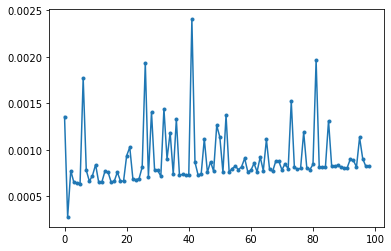

In [17]:
plt.plot(list_time, ".-")

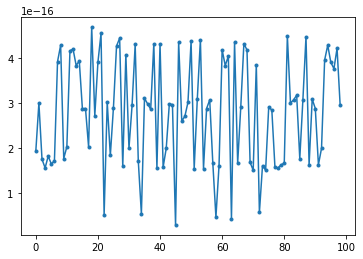

In [18]:
plt.plot(list_error, ".-")